In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import hashlib
%matplotlib inline

In [1]:
import time

In [10]:
time.asctime()

'Sun Mar 19 20:05:07 2017'

In [2]:
def normalize_num(x):
    if x[-1]=='1':
        return x+'st'
    elif x[-1]=='2':
        return x+'nd'
    elif x[-1]=='3':
        return x+'rd'
    else:
        return x+'th'

def normalize_street(x):
    street_name_mapping = {'st.':'street','st':'street','st,':'street','st..':'street','street,':'street',
                       'ave':'avenue','ave.':'avenue','ave,':'avenue','avenue,':'avenue','pl':'place',
                       'blvd':'boulevard','pkwy':'parkway','dr':'drive','rd.':'road','rd,':'road','rd':'road',
                       'ln':'lane',
                       'e':'east','e.':'east','w.':'west','w':'west','west,':'west','s':'south','&':'and',
                       'second':'2nd','first':'1st','third':'3rd','fourth':'4th','fifth':'5th',
                       'sixth':'6th','seventh':'7th','eighth':'8th','ninth':'9th','tenth':'10th',                       
                       #'1':'1st','2':'2nd','43':'43rd','37':'37th','34':'34th',
                      }
    xlist = x.lower().strip(' .,').split()
    output = []
    for tt in xlist:
        tmp = tt.strip(',.*')
        if len(tmp)>0:
            if tmp in street_name_mapping:
                tmp = street_name_mapping[tmp]
            elif tmp.isdigit():
                tmp = normalize_num(tmp)
            else:
                pass
            output.append(tmp)
    return ' '.join(output).strip()     

def rem_streetname_xy(x,y):
    '''remove x from y
    '''
    pos = y.find(x)
    if pos>0:
        tmp = y.replace(x,'').strip(' ,.')
        tmp = tmp.split(' ')[0].strip(',. #')
        if '-' in tmp:        
            tmp = tmp.split('-')[0].strip(', .#')
        try:
            a = int(tmp)
            return a
        except ValueError:
            #print tmp
            return None
    else:
        return None   

def rem_streetname(row):
    '''remove x from y
    '''
    x = row['display_address']
    y = row['street_address']
    #print x,y
    return rem_streetname_xy(x,y)

def coordinate_rotation_fn(df_,angle,center_point=(-73.9787,40.7587)):
    # Use rockefeller center as the center point
    df = df_.copy()
    df['longitude'] = df['longitude'] - center_point[0]
    df['latitude'] = df['latitude'] - center_point[1]
    aa = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),np.array([df['longitude'],
                df['latitude']]))
    df['longitude'] = aa[0]
    df['latitude'] = aa[1]
    return df

def coordinate_rotation(traindf_,testdf_):
    from sklearn.linear_model import LinearRegression
    traindf = traindf_.copy()
    testdf = testdf_.copy()
    rockefeller = (-73.9787,40.7587)
    west, south, east, north = -74.02, 40.64, -73.85, 40.86
    tmpdf = traindf[(traindf['longitude']>west)&(traindf['longitude']<east)
                        &(traindf['latitude']<north)&(traindf['latitude']>south)]
    
    x = tmpdf[tmpdf['display_address']=='west 34th street']['longitude']
    y = tmpdf[tmpdf['display_address']=='west 34th street']['latitude']
    x = x[x<-73.985]-rockefeller[0]
    y = np.array(y[x.index])-rockefeller[1]
    x = np.array(x)
    
    lr = LinearRegression()
    lr.fit(x.reshape(-1,1),y)
    angle = np.arctan(np.abs(lr.coef_[0]))
    traindf = coordinate_rotation_fn(traindf,angle,rockefeller)
    testdf = coordinate_rotation_fn(testdf,angle,rockefeller)
    return traindf,testdf

def get_address_num_simple(x):
    if len(x)==0:
        return -1
    
    x1 = x.strip().split()[0]
    if x1.isdigit():
        return float(x1)
    return -1

def street_serial(df1_,df2_):
    '''
    extract street or avenue number from displayed address. The displayed address itself will be hased to be 
    a separate feature.
    
    For those displayed address like 'w 3rd street and 5th avenue', all three fields will have values. 
    For a majority cases, one of the (west_east, street) or (avenue) will be null (0)
    '''
    
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    ave_mapping = {'lexington avenue': '3.5 avenue',
                  'park avenue':'4 avenue',
                  'madison avenue':'4.5 avenue',
                  'central park west':'8 avenue',
                  'columbus avenue':'9 avenue',
                  'amsterdam avenue':'10 avenue',
                  'west end avenue':'11 avenue'
                  }
    addr_adjust = {'central park west':5000,
                  'columbus avenue':5000,
                  'amsterdam avenue':5000,
                  'west end avenue':5000        
                }       
    
    df['west_east'] = 0 #west = -1,east = 1, null=0
    df['street_num'] = 0 # street number e.g. 12nd street will be 12, if not on a street, empty
    df['ave_num'] = 0 #avenue number, if not on avenue, empty
    df['addr_num_adjust'] = 0 # for several avenues 
    
    #import pdb;pdb.set_trace()
    
    for inx,row in df.iterrows():
        addr_str = ''
        addr_ave = ''
        
        if ' and ' in row['display_address']:
            ss = row['display_address'].split(' and ')
            if len(ss)>2:
                continue
            if ' street' in ss[0] and ' avenue' in ss[1]:
                addr_str = ss[0].strip()
                addr_ave = ss[1].strip()
            elif ' street' in ss[1] and ' avenue' in ss[0]:
                addr_str = ss[1].strip()
                addr_str = ss[0].strip()
            else:
                continue
        else:            
            if ' street' in row['display_address']:
                addr_str = row['display_address'].strip()
            if ' avenue' in row['display_address']:
                addr_ave = row['display_address'].strip()
        
        if len(addr_str)>0:
            num = re.sub('\D+','',row['display_address'])
            if len(num)>0:
                fields = addr_str.split()
                west_east = 0
                ii=0
                while ii < len(fields):
                    if fields[ii].strip() == 'west':
                        west_east = -1
                        break
                    elif fields[ii].strip() == 'east':
                        west_east = 1
                        break
                    ii += 1
                if ii<len(fields)-2:                    
                    df.set_value(inx,'west_east',west_east)   
                    try:
                        df.set_value(inx,'street_num',float(re.sub('\D+','',fields[ii+1])))
                    except ValueError:
                        pass
                        #print addr_str
                        #return None,None
        if len(addr_ave)>0:
            adjust = 0
            if addr_ave in addr_adjust:
                adjust = addr_adjust[addr_ave]
            if addr_ave in ave_mapping:
                addr_ave = ave_mapping[addr_ave]
            try:
                df.set_value(inx,'ave_num',float(re.sub('\D+','',addr_ave.split()[0])))
            except ValueError:
                #print addr_ave
                pass
            df.set_value(inx,'addr_num_adjust',adjust)
    df['address_num'] = df['address_num'] + df['addr_num_adjust']    
    del df['addr_num_adjust']
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    fea_list = ['west_east','street_num','ave_num']
    return df1,df2,fea_list
    

def multiple_hashing(df1_,df2_,col_name,nHash=3):
    from sklearn.preprocessing import LabelEncoder
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    fea_list = []
    
    all_hasher = [hashlib.sha1,hashlib.sha224, hashlib.sha256, hashlib.sha384, hashlib.sha512,hashlib.md5]
    if nHash>len(all_hasher):
        nHash = len(all_hasher)
    for ii in range(nHash):
        cname = col_name+ str(ii+1)
        df[cname] = df[col_name].map(lambda x:all_hasher[ii](x.encode("ascii","ignore")).hexdigest())
        fea_list.append(cname)
        le = LabelEncoder()
        df[cname] = le.fit_transform(df[cname])
        
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,fea_list

def address_proc():
    data_path = "../input/"
    train_file = data_path + "train.json"
    test_file = data_path + "test.json"
    train_df = pd.read_json(train_file)
    test_df = pd.read_json(test_file)
    original_col = train_df.columns
    
    train_df['address_num'] = train_df['street_address'].map(get_address_num_simple)
    test_df['address_num'] = test_df['street_address'].map(get_address_num_simple)
    train_df['display_address'] = train_df['display_address'].map(lambda x:normalize_street(x))
    test_df['display_address'] = test_df['display_address'].map(lambda x:normalize_street(x))
    flist = ['address_num']
    train_df,test_df,ff1 = street_serial(train_df,test_df)
    #train_df,test_df,ff2 = simple_hashing(train_df,test_df,'display_address')
    
    flist = flist + ff1 
    return train_df,test_df,flist

In [3]:
tt,tt2,ff = address_proc()

# Price center

In [4]:
df = tt.append(tt2)

In [8]:
onebed = tt[(tt['bedrooms']==1)&(tt['bathrooms']==1)]
studio = tt[(tt['bedrooms']==0)&(tt['bathrooms']==1)]

In [10]:
def price_center(data_):
    data = data_.copy()
    data['price_lat'] = data['price']*data['latitude']
    data['price_lon'] = data['price']*data['longitude']
    lat_center = data['price_lat'].sum()/data['price'].sum()
    lon_center = data['price_lon'].sum()/data['price'].sum()
    return lat_center,lon_center

In [11]:
price_center(onebed)

(40.742034110222, -73.96150067791767)

In [12]:
price_center(studio)

(40.74528869723376, -73.97555619030368)

In [13]:
df['price'].quantile(0.3)

2600.0

# median prices

In [514]:
df = train_df.append(test_df)
df['street_address'] = df['street_address'].map(normalize_street)
df['street_address'] = df['street_address'].map(lambda x:x.strip().strip(' .,'))

In [518]:
gp = df.groupby('street_address')['price'].median()
gp.name = 'str_addr_median'

In [520]:
gp= gp.reset_index()
gp.head()

,street_address,str_addr_median
0,,2850.0
1,02nd west 80th street #78,2650.0
2,1-9 seaman avenue,1700.0
3,10-14 47th avenue,2500.0
4,10-15 seneca avenue,1550.0


In [496]:
count = 0
for _,row in df.iterrows():
    

In [500]:
df[df['street_address'].map(lambda x: '435 East 79th Street' in x)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
110809,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-04-05 03:46:33,Located on the penthouse floor of a luxurious ...,East 79th Street,"[Doorman, Elevator, No Fee]",low,40.7716,6824704,-73.9506,9d32b720e26a351b951c8f78f72f2fec,[https://photos.renthop.com/2/6824704_02c870f0...,2700,435 East 79th Street
91567,1.0,0,0,2016-04-08 01:12:22,Apartment Features: Washer/ Dryer;Building Des...,East 79th Street,"[Doorman, Fitness Center, No Fee, Dogs Allowed...",low,40.7716,6841134,-73.9506,9fb89dd6389267ed37abbd8d78efcd6f,[],2800,435 East 79th Street
96031,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-04-12 05:37:39,Located on the penthouse floor of a luxurious ...,East 79th Street,"[Doorman, Elevator, No Fee]",low,40.7716,6860970,-73.9506,9d32b720e26a351b951c8f78f72f2fec,[https://photos.renthop.com/2/6860970_0dcc20e7...,2700,435 East 79th Street
101561,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-04-25 03:31:37,100% NO FEE!!! COME VIEW THIS LARGE SUN SOAKED...,East 79th Street,"[Elevator, Dishwasher, Hardwood Floors, No Fee]",low,40.7716,6922749,-73.9506,9f39caedae295bf81e67463e6fd0af40,[https://photos.renthop.com/2/6922749_196a3da4...,2700,435 East 79th Street
56512,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-05-05 06:26:46,Large studio with HUGE closet space! Living ar...,East 79th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",medium,40.7716,6970671,-73.9506,f8d61ab0f404fc886110b72321c77c91,[https://photos.renthop.com/2/6970671_8f9f9159...,2775,435 East 79th Street
47623,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-05-09 02:18:47,No fee! Almost 600sf spacious studio in an Ele...,East 79th Street,"[Doorman, Elevator, Dogs Allowed, Cats Allowed]",low,40.7716,6984742,-73.9506,f60efa694523ff26f61ab34e4b1dbc30,[https://photos.renthop.com/2/6984742_8cbf6e9d...,2775,435 East 79th Street
56768,1.0,0,0,2016-05-17 05:28:57,NO FEE FOR THIS SPACIOUS STUDIO IN ELEVATOR/DO...,East 79th Street,[Hardwood Floors],low,40.7716,7023298,-73.9506,2b1c151535e16536edd31719351ab544,[https://photos.renthop.com/2/7023298_e58d304b...,2725,435 East 79th Street
38961,1.0,0,0,2016-06-15 01:23:52,Alcove Studio on Upper East!Walking Distance t...,East 79th Street,"[Doorman, Fitness Center, Dogs Allowed, Cats A...",low,40.7716,7161083,-73.9506,9e0ae69813e8960d44855ef4585bb607,[https://photos.renthop.com/2/7161083_7a468045...,2775,435 East 79th Street
30646,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-06-24 02:22:59,This huge studio apartment is located in Manha...,East 79th Street,"[Doorman, Elevator, Dogs Allowed, Cats Allowed]",low,40.7716,7206532,-73.9506,1ce456323441ffd6a3b29a98cd5fc7fe,[https://photos.renthop.com/2/7206532_e42283a8...,2750,435 East 79th Street
36036,1.0,0,f115a9bff3a9c4e6eedc9114374b3d74,2016-06-26 04:06:08,Location: Upper East SideAmazing spacious stud...,East 79th Street,[Elevator],low,40.7716,7219206,-73.9506,7e22b26535b913275de0f9ff4f1d6965,[https://photos.renthop.com/2/7219206_db7212ae...,2750,435 East 79th Street


In [503]:
df.ix[99431]['street_address'].strip()

u'435 East 79th Street'

# Check if in close time windows, similar apartments gets similar interest

In [472]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
original_col = train_df.columns

In [473]:
train_df['created'] = pd.to_datetime(train_df['created'])

In [477]:
train_df = train_df.sort_values(['bedrooms','bathrooms','created'])

In [482]:
train_df[(train_df['bedrooms']==1)&(train_df['interest_level']=='high')].head(10)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
111817,1.0,1,2a21319016fe50100e0b8ebb5a4f9cf0,2016-04-01 22:12:41,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,"[Doorman, Elevator, Laundry In Building]",high,40.7302,6811957,-73.9924,f07272f8ceb99db4c1a7cbbd9ae7b75b,[https://photos.renthop.com/2/6811957_3dad56e8...,3195,1 Astor Place
83823,1.0,1,9781431e5bfa64de0f162204cc5c29c6,2016-04-02 02:21:10,LAST MINUTE DEAL!!! This apartment is now only...,India Street,[Hardwood Floors],high,40.7323,6813074,-73.9531,d96098e0b2a5de7c41bc48c6d7981b16,[https://photos.renthop.com/2/6813074_14131e6d...,1799,168 India Street
122624,1.0,1,b6e0d919003f0ad7f947c93fa68805fe,2016-04-02 02:32:05,Walk upTownhouse<br /><br />Furnished renovate...,315 W 77th St.,"[Balcony, Furnished, Hardwood Floors, No Fee]",high,40.7835,6813491,-73.9827,b944623e2af9b605eb0cba5236ee5f8e,[https://photos.renthop.com/2/6813491_f4643fe1...,2900,315 W 77th St.
86252,1.0,1,65d3666ac70e6eb7080bddcfb496e99f,2016-04-02 02:38:22,I have total market coverage in Manhattan with...,E 83 Street,[],high,40.7755,6813637,-73.9527,d2b7068bc4e5e74ba13954559d1d120d,[https://photos.renthop.com/2/6813637_b35a3722...,1900,306 E 83 Street
95536,1.0,1,09f95dd9db496bd7d12d487ec06a128a,2016-04-02 02:45:59,Hidden in the fastest growing neighborhood in ...,FiDi's Best Priced D/M Large 1 Bedroom,"[Cats Allowed, Dogs Allowed, Doorman, Elevator...",high,40.7088,6813849,-74.0059,37c44c819d8f48955183480b835bf9a3,[https://photos.renthop.com/2/6813849_32a51ae6...,2695,33 Gold Street
108996,1.0,1,c20fa2156d03512b758fbb3a79c65837,2016-04-02 02:55:55,3Bed 3Bath Penthouse Duplex w/ Washer/ Dryer +...,First Avenue,"[Balcony, Elevator, Multi-Level, Terrace, Laun...",high,40.7713,6814194,-73.9538,3e0c28a1f4b9c11b809ff21dbb920b5c,[https://photos.renthop.com/2/6814194_84f44c4d...,2500,1483 First Avenue
107956,1.0,1,5565db9b7cba3603834c4aa6f2950960,2016-04-02 03:11:39,No Fee!! Huge 1 Bedroom - utilities included i...,Broadway,"[Doorman, Elevator, Laundry in Building, Hardw...",high,40.8198,6814907,-73.9578,0e256ff13bc97e3cf7557f51870bb213,[https://photos.renthop.com/2/6814907_dbf5c6bc...,1950,3333 Broadway
114974,1.0,1,11e1dec9d14b1a9e528386a2504b3afc,2016-04-02 03:13:34,ENJOY THE ABUNDANCE OF LIGHT AND SPACE IN THIS...,West St.,"[Doorman, Elevator, Fitness Center, Pre-War, L...",high,40.7056,6815008,-74.0162,3d46c1ae1988d7ce646081408c421675,[https://photos.renthop.com/2/6815008_5ae64c06...,2260,1 West St.
103474,1.0,1,67c9b420da4a365bc26a6cd0ef4a5320,2016-04-02 05:21:39,This unit is a spacious and renovated JR 1 bed...,E 38th St,"[Doorman, Elevator, Laundry in Building, Dishw...",high,40.7488,6815499,-73.9770,66ad3cc67d71f41d549eef8b40ed26b9,[https://photos.renthop.com/2/6815499_2a526f07...,2900,137 E 38th St
121815,1.0,1,e28eb9242dace11af782b7f0b930e922,2016-04-02 05:23:49,Newly renovated rent stabilized large 1 bedroo...,Sherman Avenue,"[Multi-Level, Pre-War, Dishwasher, Hardwood Fl...",high,40.8644,6815573,-73.9248,dd2a2e03e2f73e1113ed3836bf2d9ad7,[https://photos.renthop.com/2/6815573_5b6cbcc7...,1295,120 Sherman Avenue


In [486]:
onebed = train_df[(train_df['bathrooms']==1)&(train_df['bedrooms']==1)]

In [487]:
x,y=-73.9527,40.7755
tmp = onebed[(onebed['longitude']<x+0.02)&(onebed['longitude']>x-0.02)&(onebed['latitude']>y-0.01)&(onebed['latitude']<y+0.01)]

In [488]:
len(tmp)

2354

In [490]:
tmp.loc[tmp.created<pd.to_datetime('2016-04-04')]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
103891,1.0,1,18c5b031bad8cef779efa7e2398a42a3,2016-04-02 00:48:13,Phenomenal deal of the century!! This spacious...,E 88th street,"[Cats Allowed, Dogs Allowed, Doorman, Elevator...",medium,40.7784,6811975,-73.9491,7c5e4fc025b70c6540d6b0e06716b9dd,[https://photos.renthop.com/2/6811975_370cb787...,2400,401 E 88th street
88596,1.0,1,0,2016-04-02 01:19:35,"**East 70's/First Avenue** Large, One Bedroom ...",East 75th Street,[Pre-War],low,40.7695,6812201,-73.9533,4e651379862dd496f41afe6f0a569a43,[https://photos.renthop.com/2/6812201_4518d4fd...,2100,423 East 75th Street
115189,1.0,1,0,2016-04-02 01:20:46,"Building features a DOORMAN, ELEVATOR, LAUNDRY...",East 77th Street,"[Doorman, No Fee, Dogs Allowed, Cats Allowed]",low,40.7698,6812234,-73.9512,9fb89dd6389267ed37abbd8d78efcd6f,[https://photos.renthop.com/2/6812234_03ffaf02...,3495,500 East 77th Street
83181,1.0,1,0,2016-04-02 01:21:29,Beautiful one bedroom apartment like no other!...,East 69th Street,"[Doorman, Dogs Allowed, Cats Allowed]",low,40.7675,6812258,-73.9607,5511bb6c502eaf88b51bac57f7ad0be7,[https://photos.renthop.com/2/6812258_a093d1c2...,3807,219 East 69th Street
84208,1.0,1,0fe81373d688a0a1b3ae4019cd252a9a,2016-04-02 01:40:12,,East 88th Street,"[Prewar, Dishwasher]",low,40.7792,6812729,-73.9514,62b685cc0d876c3a1a51d63a0d6a8082,[],2599,236 East 88TH Street
122744,1.0,1,26b7ab18fb7c34b2aa6c77a4e5c5a327,2016-04-02 02:13:33,Beautiful one bedroom available now!Contact La...,East 89th Street,"[Elevator, Dogs Allowed, Cats Allowed]",low,40.7810,6812933,-73.9528,4253d533689c2db18f5b6db3f432a93b,[https://photos.renthop.com/2/6812933_0fb6e4fa...,2965,171 East 89th Street
87560,1.0,1,311bcbc2494dd89450f029b6b1a6007d,2016-04-02 02:21:55,This is a Gut Renovated 1 Bedroom w/ a Private...,East 78th Street,"[Hardwood Floors, No Fee]",low,40.7723,6813116,-73.9542,9d32b720e26a351b951c8f78f72f2fec,[https://photos.renthop.com/2/6813116_6ebbe91d...,3250,323 East 78th Street
96917,1.0,1,af79d0d2ed3d31362185fed210e97cb3,2016-04-02 02:28:26,Spacious and complemented with beautiful finis...,E 82nd St.,"[Roof Deck, Dining Room, Balcony, Doorman, Ele...",low,40.7760,6813384,-73.9556,9d32b720e26a351b951c8f78f72f2fec,[https://photos.renthop.com/2/6813384_24d31474...,3800,200 E 82nd St.
85722,1.0,1,b4313c13d1141438c0a80bd494ca1b83,2016-04-02 02:29:32,***EXPOSED BRICK***70's****STAINLESS STEAL***D...,431 E 73,"[Dishwasher, Hardwood Floors]",low,40.7680,7510713,-73.9538,94db062fa1178ab999bdd777dafec65f,[https://photos.renthop.com/2/6813421_2802f6f1...,2250,431 E 73
123854,1.0,1,07ef66d6057ef14518c45ab55ecffa51,2016-04-02 02:34:12,* STYLISH MODERN 1 bedroom/ 1 bathroom apartme...,1st Ave.,"[Laundry in Unit, Dishwasher, Hardwood Floors,...",medium,40.7744,6813541,-73.9508,861afee72eb11f65b45abc0fed322417,[https://photos.renthop.com/2/6813541_cf1010e1...,2379,1582 1st Ave.


In [485]:
train_df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [491]:
from xgboost import XGBClassifier

/home/jianqi/anaconda2/envs/xgboost/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [457]:
train_df['address_num'] = train_df['street_address'].map(get_address_num_simple)
test_df['address_num'] = test_df['street_address'].map(get_address_num_simple)

In [458]:
# May not be good 
#train_df['address_num'] = train_df.apply(lambda row:rem_streetname(row),axis=1)
#train_df['address_num'] = train_df['address_num'].fillna(-1)
#test_df['address_num'] = test_df.apply(lambda row:rem_streetname(row),axis=1)
#test_df['address_num'] = test_df['address_num'].fillna(-1)

In [459]:
train_df['display_address'] = train_df['display_address'].map(lambda x:normalize_street(x))
test_df['display_address'] = test_df['display_address'].map(lambda x:normalize_street(x))

In [460]:
train_df,test_df,flist = street_serial(train_df,test_df)

In [463]:
tmp1,tmp2,flist = multiple_hashing(train_df,test_df,'display_address')

In [417]:
for xx in set(train_df.columns).difference(set(original_col)):
    print xx,sum(train_df[xx].isnull())

index 0
address_num 0
ave_num 0
street_num 0
west_east 0


In [377]:
'3 dd '.split(' and ')

['3 dd ']

# longitude and latitude is highly inaccurate, Need to find a way to correct them

In [295]:
#train_df = train_df[(train_df['longitude']>west)&(train_df['longitude']<east)&(train_df['latitude']<north)&(train_df['latitude']>south)]

In [296]:
#it turns out GPS is very unreliable.... 
train_df,test_df = coordinate_rotation(train_df,test_df)

In [297]:
tmp = train_df.groupby('display_address').size().sort_values(ascending=False)

In [339]:
avenuelist = ['2nd avenue','5th avenue','3rd avenue','10th avenue' ]

In [299]:
streetlist = list(tmp.head(20).index)

In [258]:
west, south, east, north = -74.02, 40.64, -73.85, 40.86

In [283]:
streetlist = [u'east 34th street']

In [336]:
x = train_df[train_df['display_address'].map(lambda x:x in streetlist)]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in streetlist)]['latitude']


In [335]:
streetlist=[#u'east 39th street',
 #u'east 89th street',
 #u'west 34th street',
 #u'east 35th street',
 #u'east 46th street',
 #u'west 37th street',
 #u'east 34th street',
 u'5th avenue',
 u'6th avenue',
            
]          

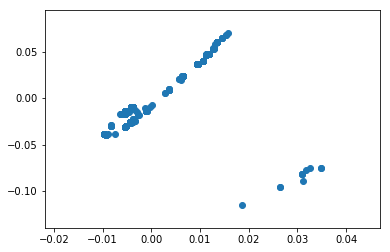

In [338]:
plt.scatter(x,y)

In [304]:
avenuelist

['2nd avenue', '1st avenue', '5th avenue', '3rd avenue', '10th avenue']

In [342]:
x = train_df[train_df['display_address'].map(lambda x:x in ['2nd avenue'])]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in ['2nd avenue'])]['latitude']


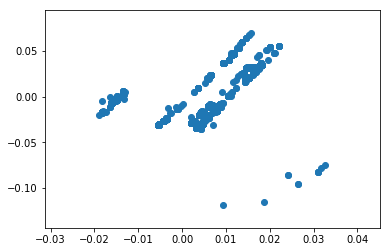

In [341]:
plt.scatter(x,y)

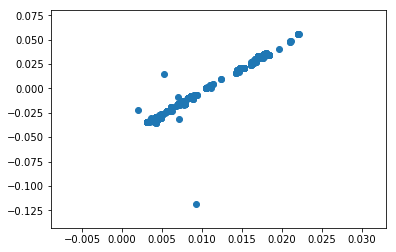

In [344]:
x = train_df[train_df['display_address'].map(lambda x:x in ['2nd avenue'])]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in ['2nd avenue'])]['latitude']
plt.scatter(x,y)

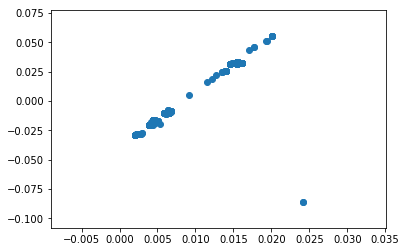

In [345]:
x = train_df[train_df['display_address'].map(lambda x:x in ['3rd avenue'])]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in ['3rd avenue'])]['latitude']
plt.scatter(x,y)

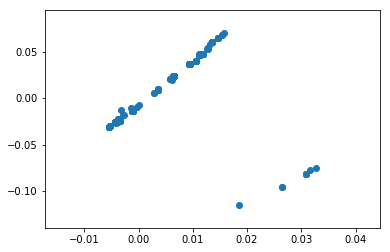

In [346]:
x = train_df[train_df['display_address'].map(lambda x:x in ['5th avenue'])]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in ['5th avenue'])]['latitude']
plt.scatter(x,y)

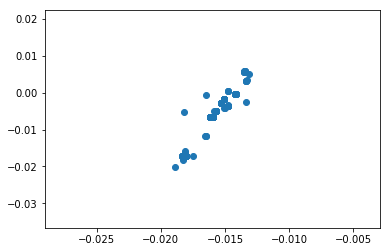

In [347]:
x = train_df[train_df['display_address'].map(lambda x:x in ['10th avenue'])]['longitude']
y = train_df[train_df['display_address'].map(lambda x:x in ['10th avenue'])]['latitude']
plt.scatter(x,y)

In [8]:
from collections import defaultdict
all_street_term_tr = defaultdict(int)
all_street_term_te = defaultdict(int)
for _,row in train_df.iterrows():
    for xx in row['display_address'].lower().split():
        all_street_term_tr[xx] +=1
for _,row in test_df.iterrows():
    for xx in row['display_address'].lower().split():
        all_street_term_te[xx] +=1
        
street_term_tr = sorted(all_street_term_tr.iteritems(),key=lambda (k,v): v,reverse=True)
street_term_te = sorted(all_street_term_te.iteritems(),key=lambda (k,v): v,reverse=True)
    

In [175]:
from sklearn.linear_model import LinearRegression

In [177]:
lr = LinearRegression()
lr.fit(x.reshape(-1,1),y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [203]:
angle = np.arctan(np.abs(lr.coef_[0]))

In [204]:
aa = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),np.array([x,y]))

In [205]:
aa.shape

(2, 188)

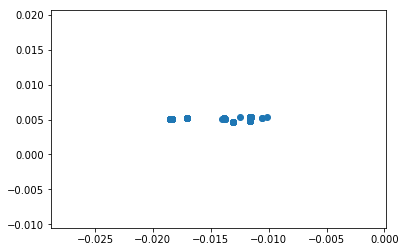

In [206]:
plt.scatter(aa[0],aa[1])

In [207]:
x = train_df[train_df['display_address']=='west 42nd street']['longitude']
y = train_df[train_df['display_address']=='west 42nd street']['latitude']
#x = x[x<-73.985]
#y = y[x.index]

In [208]:
aa = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),np.array([x,y]))

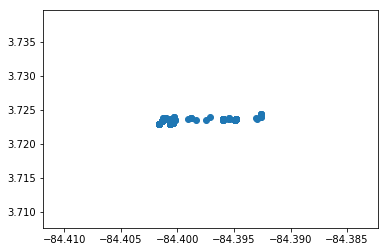

In [209]:
plt.scatter(aa[0],aa[1])

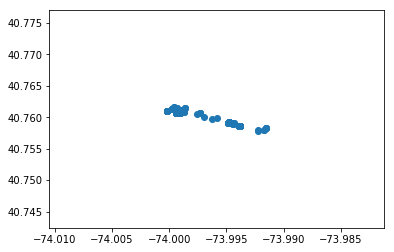

In [171]:
plt.scatter(x,y)

In [143]:
str_pos.tail(2000).head(10)

,latitude,longitude
display_address,,
east 13th,40.731775,-73.985925
east 13th and 1st avenue,40.731100,-73.984200
east 13th near 1st avenue,40.729900,-73.981900
east 13th street,40.729624,-73.983205
east 13th street and 1st avenue,40.730700,-73.983800
east 14th,40.731675,-73.983675
east 14th expo brick*true 2nd bed,40.729700,-73.979400
east 14th street,40.731172,-73.982250
east 14th street and avenue c,40.728500,-73.975700


In [144]:
train_df[train_df['display_address'].map(lambda x:'avenue b' in x)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,and,&,is_digit,address_num
102108,1.0,1,cd64e65d632c7f5d152d6c01dad5ac65,2016-04-27 06:39:12,Beautifully renovated 1 bdrm apt. located in t...,avenue b,[],low,40.7230,6933329,-73.9829,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6933329_26218ae8...,2895,44 Ave. B,False,False,True,44.0
102126,1.0,1,203f10fc864d629236fc981741e02e55,2016-04-24 04:08:13,This large 1 bedroom is located in the heart o...,avenue b,"[Laundry in Unit, Dishwasher, Hardwood Floors,...",low,40.7230,6919911,-73.9830,d959561ac12b0410f139756a3234db9a,[https://photos.renthop.com/2/6919911_9ad18da0...,2895,42 Avenue B,False,False,True,42.0
10609,2.0,3,07b0a3e316e5fb31026fee5dfa07c753,2016-06-12 04:06:45,"""Love Where You Live"" All bedrooms fit Queen b...",avenue b,"[Roof Deck, Doorman, Elevator, Fitness Center,...",low,40.7236,7146389,-73.9824,614d589dc9b706652ebc2f86d31e19ba,[https://photos.renthop.com/2/7146389_f1a3b003...,5400,62 Avenue B,False,False,True,62.0
106271,2.0,3,315a2f868a195b076e5be73411110da2,2016-04-19 04:04:27,Brand new custom renovation in beautif...,avenue b,"[Cats Allowed, Dogs Allowed]",low,40.7279,6894409,-73.9794,fc81b75568d3655a922523cb0d77ea5b,[https://photos.renthop.com/2/6894409_7ba934b9...,5295,186 Avenue B,False,False,True,186.0
106916,1.0,3,de08ea7a52b1fdccae697fd90dd761a9,2016-04-24 02:52:51,"Large, bright true 3 bedroom apartment with qu...",avenue b,"[Dishwasher, Hardwood Floors, Dogs Allowed, Ca...",medium,40.7287,6918384,-73.9788,a2745e4ddab320a1fde31d4bbbdbba47,[https://photos.renthop.com/2/6918384_995183a5...,3689,212 Ave B,False,False,True,212.0
107974,1.0,2,ad65c4ca8166e63e174834b17e2ec2de,2016-04-16 05:30:37,The Beautiful East Village. Has some great bar...,avenue b,"[Elevator, Laundry in Building, Laundry in Uni...",low,40.7228,6884356,-73.9826,5c6dccec2e084c32a67f938c9463238d,[https://photos.renthop.com/2/6884356_239c6d17...,3895,41 Avenue B,False,False,True,41.0
10851,1.0,2,f0094ee28e10b1fef114f20e6a8b7caf,2016-06-02 02:28:12,Call Marina Chukhriy For Appointments!<BR> 2 B...,avenue b,"[Pre-War, Laundry in Unit, Dishwasher, Outdoor...",low,40.7291,7095952,-73.9786,a11a3a3fed20a027150bafa6f800cf15,[https://photos.renthop.com/2/7095952_2ac1a80e...,3695,222 Avenue B,False,False,True,222.0
109887,1.0,1,cd64e65d632c7f5d152d6c01dad5ac65,2016-04-15 02:55:42,Beautifully renovated 1 bdrm apt. located in t...,avenue b,[],low,40.7230,6875986,-73.9829,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6875986_60ae966b...,2895,44 Ave. B,False,False,True,44.0
110712,1.0,1,b129ddb8998d49afdc050976d3f7237b,2016-04-18 12:34:09,"Yes for only $1250 a month this beautiful , sp...",2415th creston avenue bronx ny,[],high,40.8609,6891038,-73.8995,23005d375414d02203c8edbad655eae2,[https://photos.renthop.com/2/6891038_b6bee3e7...,1250,2415 creston ave bronx ny,False,False,True,NaN
110818,1.0,3,de08ea7a52b1fdccae697fd90dd761a9,2016-04-20 02:54:31,Come check out this AMAZINGLY BRIGHT & SPACIOU...,avenue b,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",medium,40.7287,6899174,-73.9788,ce9605e5f21262b82deb0c5ef10dcf45,[https://photos.renthop.com/2/6899174_90460950...,3689,212 Avenue B,False,False,True,212.0


In [132]:
import hashlib

In [133]:
hashlib.sha224("west 143rd street").hexdigest()

'76dfbae0b72eeb1e6ba86e5f99603baab3662ac44aeb231ca6c06af8'

In [134]:
hashlib.md5("west 143rd street").hexdigest()

'483fd417c51a53cae6460a3e4215cef0'

In [135]:
hashlib.sha224("west 143rd street").hexdigest()

'76dfbae0b72eeb1e6ba86e5f99603baab3662ac44aeb231ca6c06af8'

In [59]:
train_df['display_address'] = train_df['display_address'].map(lambda x:x.strip(' .'))
train_df['display_address'] = train_df['display_address'].map(lambda x:x.strip(' .'))


In [ ]:
train_df['address_no'] = 

In [69]:
a,b

('sssd232', 'cdsssd232ml')

In [75]:
a = r'sss\d\232'
b = r'cd33'+'sss3232d' +'ml'

In [76]:
b.replace(a,'')

'cd33sss3232dml'

In [77]:
re.sub(a,'',b)

'cd33sss3232dml'

In [78]:
import re

In [44]:
prog = re.compile('\d')

In [49]:
def is_digit(x):
    if len(x)>0 and x[0].isdigit():
        return True
    return False
train_df['is_digit'] = train_df['street_address'].map(is_digit)

In [50]:
train_df[train_df['is_digit']==False]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,and,&,is_digit
100286,1.0,0,b2736b20442923af9c2b9d2714c06a11,2016-04-27 14:59:58,This is the newest and best residential buildi...,Financial District,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",low,40.7075,6933977,-74.0113,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6933977_10c4b121...,3090,Financial District,False,False,False
100359,1.0,0,0,2016-04-12 15:41:27,"NO FEE!! NO FEE!! NO FEE!!\r\rLOOK NO FURTHER,...",E. 10th & 2nd Ave.,[No Fee],low,40.7298,6862696,-73.9868,c722e143a8b773707686f79bf5f5250c,[https://photos.renthop.com/2/6862696_8239ad5b...,2750,E. 10th & 2nd Ave.,False,True,False
100600,1.0,2,0,2016-04-13 11:13:37,This Spectacular NO FEE 2 bedroom 1 bathroom a...,UWS! NO FEE NO FEE****as,[],medium,40.7865,6868650,-73.9744,4bdc3d8c1aaa90d997ce2cb77680679b,[https://photos.renthop.com/2/6868650_6546d15e...,2500,UWS! NO FEE NO FEE****as,False,False,False
100914,1.0,2,0,2016-04-21 17:47:52,*E 25TH/3RD*Generous True 2br queen size beds ...,E 25th Street and 3rd Ave,[],high,40.7401,6908846,-73.9822,edd073f8dea85637f8b7d589faa7902b,[https://photos.renthop.com/2/6908846_b140729e...,2950,E 25th Street and 3rd Ave,True,False,False
100951,1.0,5,0,2016-04-15 04:25:34,"Brand new, beautiful tile floors in kitchen an...",Manhattan Avenue,"[Elevator, Laundry in Building, Hardwood Floors]",low,40.8025,7233989,-73.9587,d0f2082e8b795095061785ef5e8ac9e7,[https://photos.renthop.com/2/6877431_9e40c999...,6000,Manhattan Avenue,False,False,False
101075,2.0,3,0,2016-04-13 02:33:31,BRAND NEW luxury doormen building with ameniti...,... Rector Place,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",low,40.7090,6864205,-74.0169,15eed7452a6298df1c1f9d10856f5319,[https://photos.renthop.com/2/6864205_5605700b...,9600,... Rector Place,False,False,False
101433,1.0,0,0,2016-04-03 11:51:56,This spacious studio offers stainless steel ki...,Maiden Lane,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",low,40.7074,7742631,-74.0076,26d69329a0f3b9abecbddd6abcb5b622,[https://photos.renthop.com/2/6819629_02fbbf07...,3100,Maiden Lane,False,False,False
101454,1.0,2,5138ef00289a9b9a574efcb9b2f60fc9,2016-04-30 13:11:54,2 QUEEN SIZE BEDROOMS with a LARGE LIVING ROOM...,330 east 30th street,"[Cats Allowed, Dogs Allowed, Doorman, Elevator...",medium,40.7128,6948401,-74.0059,67e232e16c6614f1a9e543d91db326d7,[https://photos.renthop.com/2/6948401_5ec18ac3...,2700,340 east 30th street,False,False,False
101646,1.0,1,cd5dbf58ff7014957be69643a96aaaf5,2016-04-29 02:59:02,WEDDING BELLS RINGING? Spacious living/dining ...,The Lucerne 350 East 79th Street,"[Fitness Center, Indoor Pool, Residents Lounge...",low,40.7723,6940852,-73.9533,9df32cb8dda19d3222d66e69e258616b,[https://photos.renthop.com/2/6940852_2fac44fe...,4095,The Lucerne 350 East 79th Street,False,False,False
101805,1.0,2,0,2016-04-11 13:16:09,This convertible 2 apartment is spacious and o...,West St,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",medium,40.7040,6856621,-74.0078,d12f4c3b61d726c5b7f74ffda19ad9ce,[https://photos.renthop.com/2/6856621_2c18feac...,2750,West St,False,False,False


In [98]:
train_df[train_df['street_address'].map(lambda x: '149 Huron Street' in x)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,and,&,is_digit,address_num
118617,1.0,1,0,2016-04-18 02:23:48,Modern Spacious 1 Bedroom Duplex in a prime Gr...,Huron Street (rental,"[Laundry in Unit, Dishwasher, Hardwood Floors]",low,40.7283,6888773,-73.9507,c6ce7209106a337a80cd63ed8fbac33b,[https://photos.renthop.com/2/6888773_9ea6ef98...,2800,149 Huron Street (rental,False,False,True,<function rem_streetname at 0x7f63783acaa0>
92815,1.0,1,d968ec0781a69591cb0078e05b88b5f8,2016-04-10 03:09:08,This spectacular loft-like rental is situated ...,Huron Street,"[Balcony, Elevator, Fitness Center, Garden/Pat...",medium,40.7330,6852037,-73.9556,19bc090c14e88401ebcde3b994e0b078,[https://photos.renthop.com/2/6852037_21add0e3...,2950,149 Huron Street,False,False,True,<function rem_streetname at 0x7f63783acaa0>


In [10]:
train_df['and'] = train_df['display_address'].map(lambda x:'and' in x)
train_df['&'] = train_df['display_address'].map(lambda x:'&' in x)

In [11]:
train_df[train_df['and']]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,and,&
100124,1.0,2,a6fb47bf44e73e699b9acf3d8cde48f0,2016-04-11 15:59:59,Beautiful true QUEEN 2BR / 1Bath with an abund...,3rd Ave and East 22nd Street,"[Common Outdoor Space, Laundry In Unit, Cats A...",low,40.7377,6856713,-73.9831,046ed6c8a67bc942fcf4ca43e96f27d8,[https://photos.renthop.com/2/6856713_2cf10a0b...,5595,210 East 22nd St #1B,True,False
100302,1.0,2,bcf77c615fe44ac44eef4bac15293c73,2016-04-20 20:35:06,New to the market! Enormous two bedroom with l...,York Ave and 84th Street,[],low,40.7751,6903190,-73.9481,370a9b35c74f968387f3be370fbed8e6,[https://photos.renthop.com/2/6903190_68cc7c4d...,2475,1601 York Ave,True,False
100465,1.0,4,78a015c283c35d4c8726d1bb826f54b0,2016-04-08 00:37:54,Let's get you in to see this recently renovate...,E. 6th St and 2nd Ave,[],high,40.7274,6841075,-73.9882,b6366b42ae29a86e2e33ffc66cfeafc7,[https://photos.renthop.com/2/6841075_65b78429...,5800,104 2nd Ave,True,False
100563,1.0,1,14dc0fbfba429131eec42c3bb545fb45,2016-04-21 17:48:04,Rare find.\r\rLarge Duplex / Triplex 1 bdrm on...,East 87th Street and First Ave,"[Triplex, Dishwasher, On-site super]",medium,40.7775,6908847,-73.9483,92758310b2a962b943484e8be0237a19,[https://photos.renthop.com/2/6908847_7c93dfe3...,2550,403 E 87th Street,True,False
100876,1.0,2,0,2016-04-14 01:17:53,Building Description: Voice Intercom; Walk-Up;...,Grand Avenue,[Pre-War],low,40.8600,6869303,-73.9052,0da38e009d387cb435f1aa12c4250d6a,[https://photos.renthop.com/2/6869303_b05560ca...,1695,2305 Grand Avenue,True,False
100914,1.0,2,0,2016-04-21 17:47:52,*E 25TH/3RD*Generous True 2br queen size beds ...,E 25th Street and 3rd Ave,[],high,40.7401,6908846,-73.9822,edd073f8dea85637f8b7d589faa7902b,[https://photos.renthop.com/2/6908846_b140729e...,2950,E 25th Street and 3rd Ave,True,False
101035,1.0,2,25504bce65bf4185c96a0d59fe861ad6,2016-04-05 01:02:05,"NO FEE, 2 Bedroom, 1 Bath in Prime Crown Heigh...",Nostrand Avenue,"[Outdoor Areas, No Fee]",low,40.6692,6822568,-73.9503,31724ced2fc02a025147233c542d8623,[https://photos.renthop.com/2/6822568_e66ffe93...,2395,803 Nostrand Avenue,True,False
101373,1.0,0,c9b6a091ad6adf92bb0386b9eda24965,2016-04-22 11:09:22,Studio with outdoor space.,W 10 and Waverly Place,[],medium,40.7344,6913669,-74.0010,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6913669_26920a83...,2650,146 W 10,True,False
102112,1.0,1,0,2016-04-30 03:28:01,This is it!! A Spacious One Bedroom One Bathro...,Kingsland Ave,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",medium,40.7237,6946312,-73.9416,25ef68c6cfd3cb0d0b1df2f39e78f6ac,[https://photos.renthop.com/2/6946312_7f1e1726...,2000,209 Kingsland Ave,True,False
102575,1.0,1,99eb2de0855db6ce80167f48adc5458e,2016-04-15 01:14:16,This is an incredible rental. You should absol...,Broadway and W. 100th,"[Elevator, Laundry In Building]",low,40.7974,6874683,-73.9708,b6366b42ae29a86e2e33ffc66cfeafc7,[https://photos.renthop.com/2/6874683_e98e7d69...,2525,250 W. 100th,True,False


In [12]:
train_df[train_df['&']]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,and,&
100132,1.0,1,4d7c804afea366c666731bee9c56919e,2016-04-09 02:34:39,NO Brokers FEE !! Renovated LARGE ALCOVE STUDI...,W 80's & Broadway,"[No Fee, Doorman, Elevator, Fitness Center, Sw...",low,40.7890,6847390,-73.9756,e0af09eba42a9af0626d15c8d9505043,[https://photos.renthop.com/2/6847390_e29e480d...,3300,247 W 87th St.,False,True
100359,1.0,0,0,2016-04-12 15:41:27,"NO FEE!! NO FEE!! NO FEE!!\r\rLOOK NO FURTHER,...",E. 10th & 2nd Ave.,[No Fee],low,40.7298,6862696,-73.9868,c722e143a8b773707686f79bf5f5250c,[https://photos.renthop.com/2/6862696_8239ad5b...,2750,E. 10th & 2nd Ave.,False,True
100640,1.0,2,9fad2bc9fbb983dfa8586df2f7fc3378,2016-04-24 03:59:58,"Modern renovations throughout, with flowing sp...",Beautiful Spacious Renovated Modern Kitchen & ...,"[Cats Allowed, Dogs Allowed, No Fee, Reduced F...",medium,40.8233,6919760,-73.9532,2a4e0d2668fde3afa267d312b3a2a9d8,[https://photos.renthop.com/2/6919760_455c9cce...,1900,600 W 140,False,True
10095,1.0,1,c26509ae2a74ee9ca8bfeb98cb7c697b,2016-06-20 12:05:12,ASTORIA APARTMENTS LLC | JOANNE | 142-991-147...,*Hot 30th Ave*4 Blk to N&Q!!Walk to Restaurant...,[Reduced Fee],medium,40.7658,7181422,-73.9171,212effbcc8f31fdb80b8dc41917a2661,[https://photos.renthop.com/2/7181422_5eca9d8b...,1750,28-36 36TH STREET,False,True
10120,1.0,3,99700df4439e3d4fdcbceedffddaab66,2016-06-09 17:54:35,Underpriced 3Br just minutes from PRATT\rRecen...,Lafayette Ave & Franklin Ave,"[Cats Allowed, Dogs Allowed, No Fee, Air Condi...",high,40.6889,7132994,-73.9576,20e0820480fe4c7a74bce987c2e85827,[https://photos.renthop.com/2/7132994_3e0182b0...,2799,444 Lafayette Ave,False,True
101927,1.0,2,0,2016-04-19 19:56:01,Spacious 2 bedroom apartment available for Jun...,Rivington St & Bowery St,[Dishwasher],medium,40.7215,6897346,-73.9931,a1e83422f637157e3c14ab88d585b769,[https://photos.renthop.com/2/6897346_7da1d42e...,3195,8 Rivington St (Between Chrystie & Bowery),False,True
102274,1.0,3,360d4d3a2c6416c48b89ffa2e3eb6cfc,2016-04-03 02:23:11,"Comfortable spacious renovated apartment, with...",Beautiful Spacious Renovated Modern Kitchen & ...,"[Cats Allowed, Dogs Allowed, No Fee, Reduced F...",low,40.8254,6818149,-73.9525,2a4e0d2668fde3afa267d312b3a2a9d8,[https://photos.renthop.com/2/6818149_a2e3cac9...,2400,610 W 143rd St.,False,True
102473,1.0,2,205f95d4a78f1f3befda48b89edc9669,2016-04-04 23:40:29,DEAL ALERT!!! This is a SUPER SPACIOUS 2 Bedro...,30th St & Madison Avenue,"[Cats Allowed, Dogs Allowed, No Fee, Reduced F...",low,40.7453,7309872,-73.9844,3b630ec9cb6eee53b92cfac7f42e3bf4,[https://photos.renthop.com/2/7309872_a5334567...,3000,121 Madison Avenue,False,True
102752,1.0,3,dec4894bd1427eccb7b8b094f8545647,2016-04-03 03:40:29,This renovated gorgeous apartment with spaciou...,Beautiful Spacious Renovated Modern Kitchen & ...,"[Cats Allowed, Dogs Allowed, No Fee, Reduced F...",medium,40.8439,6819205,-73.9413,2a4e0d2668fde3afa267d312b3a2a9d8,[https://photos.renthop.com/2/6819205_e5fb8088...,2400,257 Ft Washington,False,True
102943,1.0,1,146060fb99c371080bb8f0c8e9980b9b,2016-04-07 13:46:40,1BR Beauty In Clinton Hill!! Elevator/Laundry ...,Washington Ave & Dekalb Avenue,"[Elevator, Laundry In Building, Dishwasher, Ha...",high,40.6905,6840675,-73.9668,c71cf1f472cf9b4b4517ea23fb6f2c91,[https://photos.renthop.com/2/6840675_c22f14c3...,2600,266 Washington Avenue,False,True
